# Обучение mnist классификатора

В этой части мы обучим классификатор рукописных цифр с помощью simple_nn библиотеки.

In [1]:
import unittest
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as sps
import seaborn as sns
import pickle
# sns.set(font_scale=1.6)

import simple_nn.mnist as mnist
from simple_nn.layers import DenseLayer, ReluLayer, SoftMaxLayer, LeakyReluLayer, SigmaLayer
from simple_nn.loss_functions import MSE
from simple_nn.optimizers import SGD, LazyOptimizer
from simple_nn.model import Model
from simple_nn.utils import one_hot_digit


mnist_data = mnist.load_mnist()
train_images = mnist_data['training_images']
train_labels = mnist_data['training_labels']
test_images = mnist_data['test_images']
test_labels = mnist_data['test_labels']

train_size = train_labels.shape[0]
test_size = test_labels.shape[0]
train_images = train_images / 255.
test_images = test_images / 255.

Создадим просутю модель из трёх полносвязных слоёв.

In [2]:
model = Model()
model.add_layer(DenseLayer(input_size=28*28, output_size=32))
model.add_layer(LeakyReluLayer())
model.add_layer(DenseLayer(input_size=32, output_size=16))
model.add_layer(LeakyReluLayer())
model.add_layer(DenseLayer(input_size=16, output_size=10))
model.add_layer(SoftMaxLayer())

In [3]:
def get_test_metrics():
    test_output = model.forward(test_images)
    test_output_labels = np.argmax(test_output, axis=-1)
    mse = MSE().forward(test_output, one_hot_digit(test_labels))
    
    return {
        'test_sucsess_rate': np.mean(test_output_labels == test_labels),
        'test_mse': mse,
        'test_rmse': mse ** 0.5,
    }

Установим глобальные переменные и запустим цикл обучения.

In [4]:
batch_size = 4096
learning_steps = 1000
learning_rate = 10
sample_rate = 10
print_rate = 100
training_stats = pd.DataFrame()

In [5]:
for batch_id in range(learning_steps):
    batch_indexes = np.random.choice(train_size, batch_size, replace=False)
    batch_images = train_images[batch_indexes]
    batch_desired = one_hot_digit(train_labels[batch_indexes])
    mse = model.fit(batch_images, batch_desired, MSE(), SGD(learning_rate=learning_rate))
    
    test_metrics = dict()
    if batch_id % sample_rate == 0:
        test_metrics = get_test_metrics()
    
    training_stats = training_stats.append({
        **{
            'train_mse': mse,
            'train_rmse': mse ** 0.5,
        }, **test_metrics
    }, ignore_index=True)
    
    if batch_id % print_rate == 0 or batch_id == learning_steps - 1:
        print(f'train_rmse={training_stats.train_rmse.dropna().values[-1]:.2} '\
              f'test_rmse={training_stats.test_rmse.dropna().values[-1]:.2} '\
              f'test_sucsess_rate={training_stats.test_sucsess_rate.dropna().values[-1]:.2}')

train_rmse=0.32 test_rmse=0.33 test_sucsess_rate=0.1
train_rmse=0.22 test_rmse=0.2 test_sucsess_rate=0.72
train_rmse=0.12 test_rmse=0.12 test_sucsess_rate=0.9
train_rmse=0.13 test_rmse=0.13 test_sucsess_rate=0.9
train_rmse=0.1 test_rmse=0.11 test_sucsess_rate=0.93
train_rmse=0.11 test_rmse=0.1 test_sucsess_rate=0.93
train_rmse=0.086 test_rmse=0.095 test_sucsess_rate=0.94
train_rmse=0.091 test_rmse=0.096 test_sucsess_rate=0.94
train_rmse=0.084 test_rmse=0.091 test_sucsess_rate=0.95
train_rmse=0.087 test_rmse=0.09 test_sucsess_rate=0.95
train_rmse=0.083 test_rmse=0.088 test_sucsess_rate=0.95


Ниже представлены графики метрик обучения

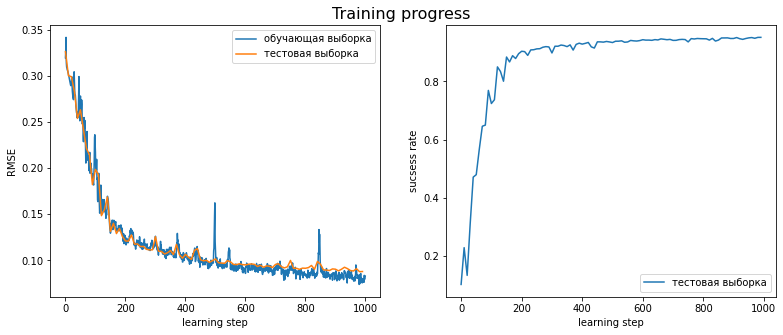

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
axes = axes.reshape(-1)
fig.suptitle('Параметры распределения промежуточных значений', fontsize=15)


sns.lineplot(data=training_stats, x=training_stats.index, y='train_rmse', label='обучающая выборка', ax=axes[0])
sns.lineplot(data=training_stats, x=training_stats.index, y='test_rmse', label='тестовая выборка', ax=axes[0])
sns.lineplot(data=training_stats, x=training_stats.index, y='test_sucsess_rate', label='тестовая выборка', ax=axes[1])

plt.suptitle('Training progress', fontsize=16, y=.93)
plt.legend(fontsize=10)
axes[0].set_xlabel('learning step')
axes[0].set_ylabel('RMSE')
axes[1].set_xlabel('learning step')
axes[1].set_ylabel('sucsess rate')
plt.show()

Интерес представляет первый слой нейронной сети, поскольку он действует напрямую на входящие изображения, несложно получить интересную картину весов.

[]

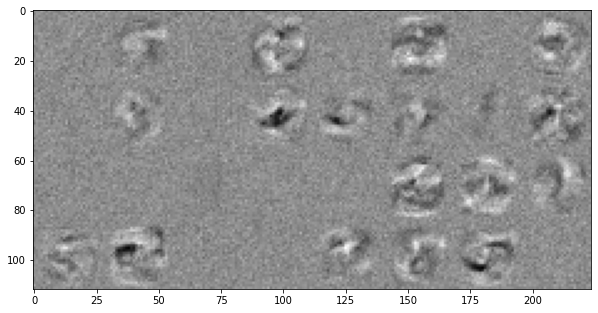

In [7]:
plt.figure(figsize=(10, 10))
images = model.layers[0].get_values()[0].reshape(8, 28 * 4, 28)
images = images.swapaxes(1,2).reshape(28 * 8, 28 * 4).T
plt.imshow(images, cmap='gray')
plt.plot()

Также можно проанализировать то, какие в сети значения и градиенты.

In [8]:
model.fit(test_images, one_hot_digit(test_labels), MSE(), LazyOptimizer())
propogation_hidden_stats = pd.DataFrame()
for layer in model.layers:
    for value, value_grad in zip(layer.get_values(), layer.get_gradients()):
        propogation_hidden_stats = propogation_hidden_stats.append({
            'value_mean': np.mean(value),
            'value_std': np.std(value),
            'value_abs_mean': np.std(np.abs(value)),
            'value_grad_mean': np.mean(value_grad),
            'value_grad_std': np.std(value_grad),
            'value_grad_abs_mean': np.std(np.abs(value_grad)),
        }, ignore_index=True)

propogation_hidden_stats

,value_mean,value_std,value_abs_mean,value_grad_mean,value_grad_std,value_grad_abs_mean
0,-0.001281,0.060622,0.043260,2.992883e-06,0.000039,0.000037
1,-0.228248,1.146925,0.752410,2.166777e-05,0.000135,0.000116
2,-0.001688,0.299805,0.194278,9.716598e-06,0.000154,0.000136
3,0.377185,0.985087,0.654203,1.789970e-05,0.000147,0.000104
4,-0.005602,0.540685,0.335215,0.000000e+00,0.000254,0.000217
5,0.121396,0.774401,0.434592,-1.236668e-19,0.000107,0.000079


И то, как меняются вектора, протекая через сеть.

In [9]:
model.forward(test_images)
propogation_stats = pd.DataFrame()
for value_slice in model.run_data:
    propogation_stats = propogation_stats.append({
        'value_slice_mean': np.mean(value_slice),
        'value_slice_std': np.std(value_slice),
    }, ignore_index=True)

propogation_stats

,value_slice_mean,value_slice_std
0,0.132515,0.310480
1,-0.564345,1.971434
2,0.476264,1.233203
3,0.657642,3.196749
4,1.525803,2.353470
5,-0.399752,5.775106
6,0.100000,0.287306


Также можно построить confusion matrix для тестовой выборки.

In [10]:
test_logits = model.forward(test_images)
test_numbers = np.argmax(test_logits, axis=-1)
test_results = pd.DataFrame({
    'test_id': range(len(test_labels)),
    'test_number': test_numbers,
    'true_number': test_labels
})

confusion_matrix = pd.pivot_table(test_results, index=['test_number'], columns=['true_number'], values='test_id', aggfunc=len)
confusion_matrix = confusion_matrix.fillna(value=0)

confusion_matrix

true_number,0,1,2,3,4,5,6,7,8,9
test_number,,,,,,,,,,
0,965.0,0.0,10.0,1.0,1.0,7.0,14.0,2.0,2.0,8.0
1,0.0,1114.0,2.0,1.0,0.0,1.0,3.0,8.0,5.0,7.0
2,3.0,4.0,967.0,15.0,4.0,1.0,6.0,23.0,5.0,1.0
3,1.0,4.0,4.0,960.0,0.0,13.0,0.0,5.0,10.0,10.0
4,0.0,0.0,10.0,0.0,934.0,1.0,8.0,3.0,2.0,21.0
5,3.0,1.0,0.0,8.0,1.0,836.0,11.0,0.0,6.0,10.0
6,3.0,3.0,4.0,0.0,9.0,8.0,910.0,0.0,8.0,0.0
7,2.0,2.0,9.0,8.0,5.0,2.0,1.0,959.0,2.0,9.0
8,3.0,7.0,26.0,13.0,8.0,16.0,5.0,5.0,932.0,13.0


Сохраним модель в файл.

In [11]:
with open('mnist_classificator.pickle', 'wb') as file:
    pickle.dump(model, file)